# TM10007 Assignment template

Elise Lie (4651324), Bart de Vries (5399009), Noa Nicolai (4551230) en Lisa Arkes (4556216)

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git



In [ ]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adni.load_data import load_data 
from sklearn.decomposition import PCA

# Classifiers
from sklearn import model_selection,feature_selection, preprocessing, neighbors
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, classification_report
#from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import RandomizedSearchCV # HalvingRandomSearchCV, HalvingGridSearchCV, GridSearchCV --> different search methods
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform


# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

import warnings


warnings.filterwarnings("ignore")


## Data loading, cleaning and evaluation






In [ ]:
# Data loading
data = load_data()
features=list(data.columns)
Y = data.pop('label')

# Renaming the labels
Y = Y.replace(to_replace = "AD", value = 1)
Y = Y.replace(to_replace= "CN", value = 0)
X = data


In [ ]:
# Number of patient and features
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

#Imputation of missing data
if X.isnull().values.any():
  # Iterate over the sequence of column names
  for column in data:
    # Select column contents by column name using [] operator
    column_series = data[column]
    ratio_nans = column_series.isnull().sum()/len(data.index)

    # Deterministic local threshold for replacing cell or popping feature
    invalid_ratio = 0.25

    if ratio_nans > invalid_ratio:
      del data[column]
      print(f'Feature {column} is removed from data')
    else:
      data[column] = column_series.where(column_series == 'NaN', 
                                         np.mean(column_series))
      print(f'Cells along feature {column} are imputated using mean value of the feature')
else:
  print('No NaN present in data - No imputation required')


The number of samples: 855
The number of columns: 267
No NaN present in data - No imputation required


In [ ]:
# Splitting the data
# Split the dataset in train and test part
X_train_val, X_test, Y_train_val, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, stratify=Y)

# Split the dataset in train and val part
cv_10fold = model_selection.StratifiedKFold(n_splits=5)

# Defining possible scalers
scalers = [preprocessing.StandardScaler(), preprocessing.MinMaxScaler(),preprocessing.MaxAbsScaler()]

In [ ]:
# Defining possible Classifiers
clsfs_lcp = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),
         LogisticRegression(),SGDClassifier(), SVC(),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(),KNeighborsClassifier()]


In [ ]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

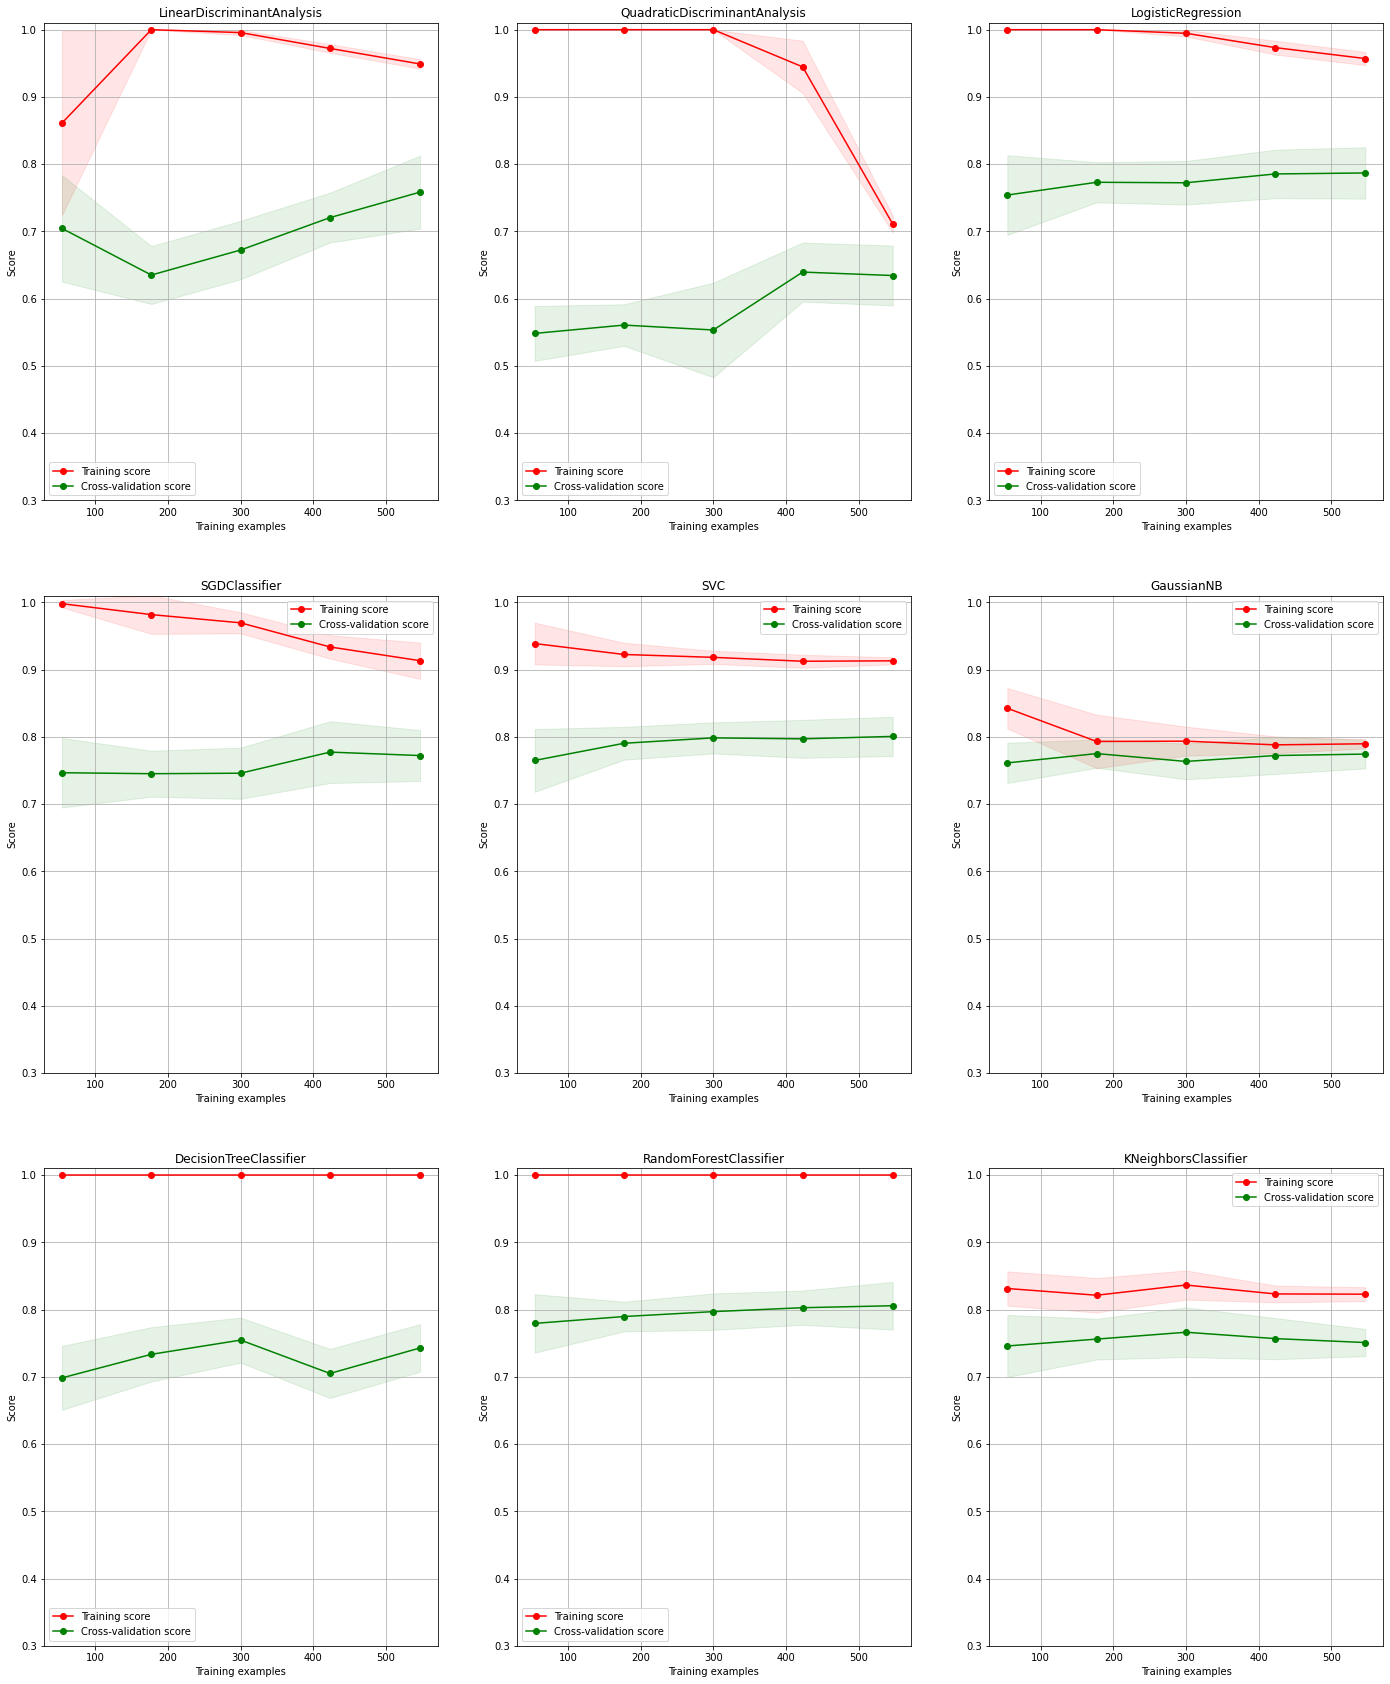

In [ ]:
sclr = scalers[0]
sclr.fit(X_train_val)
X_scaled = sclr.transform(X_train_val)

#Creating learning curve plots gives a first indication how complex our data is,
#and how complex our model should be
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
fig = plt.figure(figsize=(24,8*len(clsfs_lcp)))  

# Now use the classifiers on all datasets
num = 0
for clf in clsfs_lcp:
    # Split data in training and testing
    title = str(clf.__class__.__name__)
    ax = fig.add_subplot(7, 3,  num + 1)
    plot_learning_curve(clf, title, X_scaled, Y_train_val, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1

## Defining scalar, PCA, classifier and hyperparameters

In [ ]:
#Parameters with relevant hyperparameters
param_grid_LDA = {'solver': ['svd', 'lsqr', 'eigen']}
param_grid_LR = {'C': loguniform(0.001, 1000)}
param_grid_SGD = {"loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : loguniform(0.0001, 0.1),
    "penalty" : ["l2", "l1", "none"]}
param_grid_SVC = {'kernel': ('linear', 'rbf', 'poly'),
            'C': loguniform(0.1,100),
            "gamma": ['scale', 'auto']}
param_grid_NB = {'var_smoothing': loguniform(10e-13,10e-9)},
param_grid_kNN = {"n_neighbors" : range(1,15,1), 
                "weights" : ["uniform", "distance"]}


# Defining relevant parameters
params = [param_grid_LDA,param_grid_LR, param_grid_SGD,param_grid_SVC, 
          param_grid_NB, param_grid_kNN]   

# Defining relevant Classifiers
clsfs = [LinearDiscriminantAnalysis(),LogisticRegression(),SGDClassifier(), 
         SVC(), GaussianNB(),KNeighborsClassifier()]

In [ ]:

# Creating dataframe to save results
df = pd.DataFrame({'fold':[],'var_comp': [], 'pca_train' : [],
                   'train_label' : [], 'pca' : [], 'acc':[], 'clf_name':[],
                   'clf':[],'scaler': []})

# RandomSearch of parameters
fold = 1
for train_index, val_index in cv_10fold.split(X_train_val, Y_train_val):
    # Split the data properly
    X_train = X_train_val.values[train_index]
    Y_train = Y_train_val.values[train_index]
    
    X_val = X_train_val.values[val_index]
    Y_val = Y_train_val.values[val_index] 
    for scaler in scalers:
      print(f'Fitting scaler: {scaler.__class__.__name__}')
      # Scale the dataset
      scaler.fit(X_train)
      X_train_scaled = scaler.transform(X_train)
      X_val_scaled = scaler.transform(X_val)
      
      # Perform a PCA
      for var_comp in range(75, 102, 3):
        pca = PCA(n_components=var_comp*0.01)
        pca.fit(X_train_scaled)
        X_train_pca_a = pca.transform(X_train_scaled)
        X_train_pca = pd.DataFrame(X_train_pca_a)
        X_val_pca = pca.transform(X_val_scaled)

        for clf, param in zip(clsfs, params):
          sh = RandomizedSearchCV(clf, param_distributions=param, 
                                  scoring='accuracy', cv=3, 
                                  n_jobs = -1).fit(X_train_pca, Y_train)

          Y_score_train = sh.best_estimator_.score(X_train_pca,Y_train)
          Y_score_val = sh.best_estimator_.score(X_val_pca,Y_val)
          clf = sh.best_estimator_

          results = pd.DataFrame({
               'fold': [fold],
               'var_comp': [var_comp],
               'pca_train' : [X_train_pca_a],
               'train_label' : [Y_train],
               'pca' : [pca],
               #'test_label' : [Y_test],
               'acc': [Y_score_val],
               'clf_name': [clf.__class__.__name__],
               'clf' : [clf],
               'scaler_name': [scaler.__class__.__name__],
               'scaler': [scaler]
               })
            
          df = pd.concat([df,results],axis=0, ignore_index=True)
            
    fold +=1

df = df.sort_values(by=['clf_name','scaler_name','var_comp'], ascending=False)


Fitting scaler: StandardScaler
Fitting scaler: MinMaxScaler
Fitting scaler: MaxAbsScaler
Fitting scaler: StandardScaler
Fitting scaler: MinMaxScaler
Fitting scaler: MaxAbsScaler
Fitting scaler: StandardScaler
Fitting scaler: MinMaxScaler
Fitting scaler: MaxAbsScaler
Fitting scaler: StandardScaler
Fitting scaler: MinMaxScaler
Fitting scaler: MaxAbsScaler
Fitting scaler: StandardScaler
Fitting scaler: MinMaxScaler
Fitting scaler: MaxAbsScaler


In [ ]:
# Validation
df_mean = df.groupby(['clf_name','scaler_name','var_comp']).mean()
df_mean = df_mean.rename(columns={"acc": "acc_mean"})
df_std = df.groupby(['clf_name','scaler_name','var_comp']).std()
df_std = df_std.rename(columns={"acc": "acc_std"})
df_result = pd.concat([df_mean['acc_mean'],df_std['acc_std']],axis=1)
df_result = df_result.sort_values(by='acc_mean',ascending=False)
test = pd.DataFrame(df_result)

print(df_result[0:11])


                                                    acc_mean   acc_std
clf_name                   scaler_name    var_comp                    
SGDClassifier              MinMaxScaler   99.0      0.829004  0.032599
LinearDiscriminantAnalysis MinMaxScaler   84.0      0.826106  0.044246
SGDClassifier              MinMaxScaler   84.0      0.824667  0.050300
LogisticRegression         MinMaxScaler   84.0      0.823186  0.044830
SGDClassifier              MinMaxScaler   90.0      0.823164  0.032474
SVC                        MaxAbsScaler   99.0      0.821748  0.056900
LogisticRegression         MinMaxScaler   87.0      0.820266  0.046622
SGDClassifier              MaxAbsScaler   93.0      0.818828  0.052710
LogisticRegression         StandardScaler 90.0      0.818806  0.042049
SVC                        MinMaxScaler   84.0      0.818806  0.042049
LogisticRegression         StandardScaler 87.0      0.817347  0.051600


Accuracy of SGDClassifier(alpha=0.007130349672132408, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) is 0.8070175438596491
Sensitivity of SGDClassifier(alpha=0.007130349672132408, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) is 0.8173076923076923
Specificity of SGDClassifier(alpha=

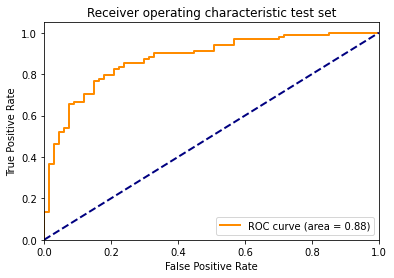

In [ ]:
# Selecting parameters
best_set = df_result.iloc[0]
clf = best_set.name[0]
scl = best_set.name[1]
var_comp = best_set.name[2]
df_new = df[(df['clf_name'] == clf) & (df['scaler_name'] == scl) & 
            (df['var_comp'] == var_comp)]

idx = int(df_new['acc'].argmax())
df_max = df_new.iloc[idx]
scaler = df_max['scaler']
pca = df_max['pca']

# Apply scaler + pca to test set
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

clf = df_max['clf']

Y_score = clf.decision_function(X_test_pca)
y_pred = clf.predict(X_test_pca)

# Evalution perfomance 
acc = clf.score(X_test_pca,Y_test)
scores = classification_report(Y_test, y_pred, labels= [0,1], output_dict=True)

# Extracting sens and spec
sens = scores['1']
sens = sens['recall']
spec = scores ['0']
spec = spec ['recall']

# Printing the perfomance different metrices
print(f'Accuracy of {clf} is {acc}')
print(f'Sensitivity of {clf} is {sens}')
print(f'Specificity of {clf} is {spec}')

# Creating ROC plot
fpr, tpr, _ = roc_curve(Y_test,Y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic test set')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Color plot

def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)
            
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

## Visualitation  



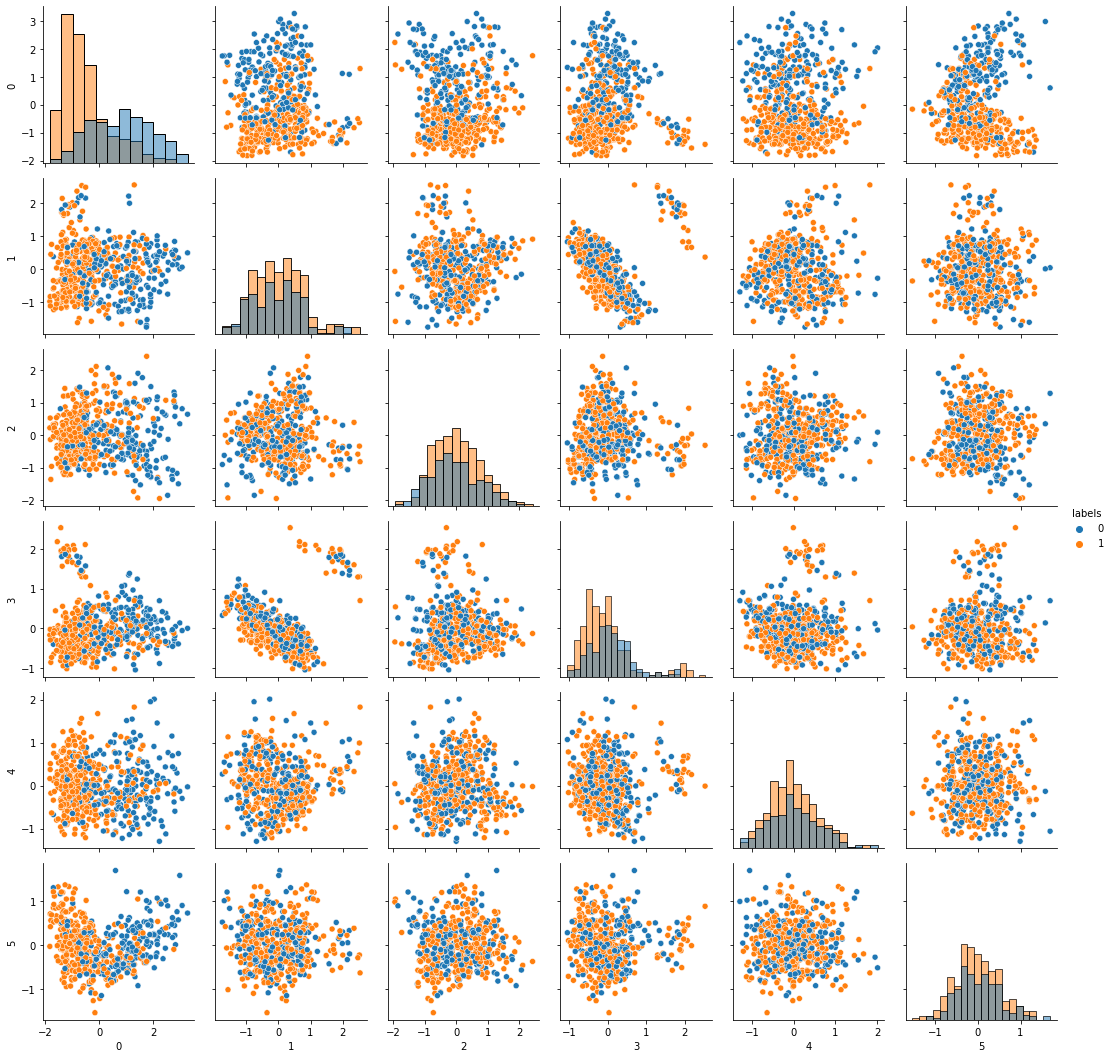

In [ ]:
# Scatter plot first 5 pca components
Y_train = pd.DataFrame(Y_train)
Y_train = Y_train.rename(columns={0:"labels"})
dfs = pd.DataFrame(df_max['pca_train'])
dfs = dfs.iloc[:,:6]
dfx = pd.concat([dfs,Y_train],axis=1)


g = sns.PairGrid(dfx, hue="labels")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()


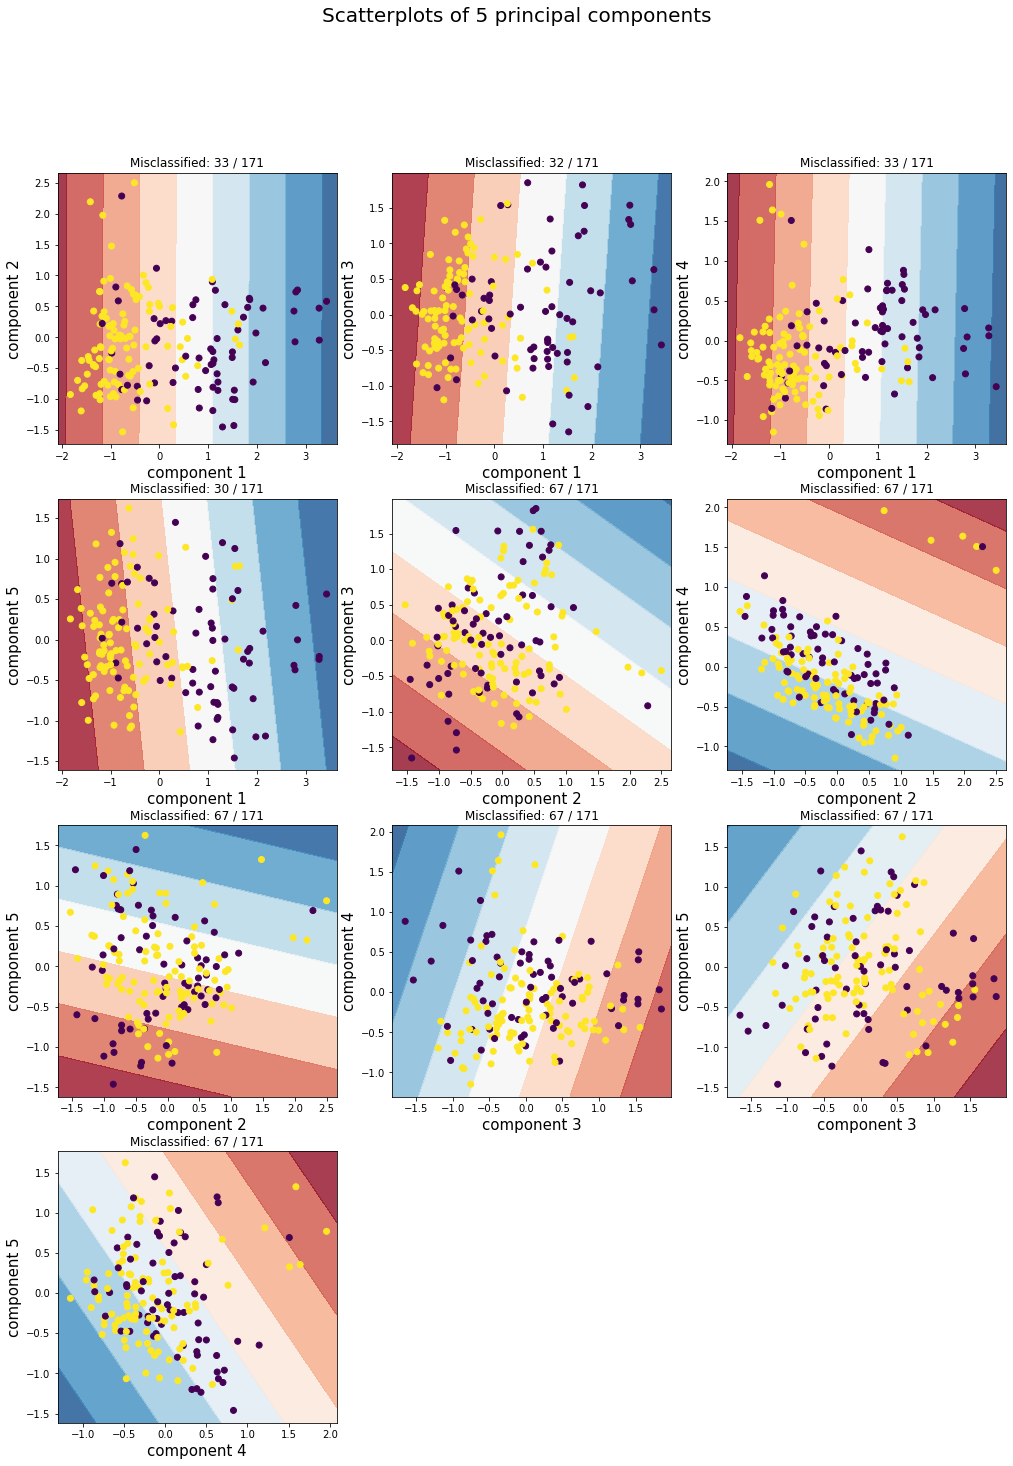

In [ ]:
# Color plot of the first 5 pca components 
combinations = [[0, 1], [0, 2], [0, 3], [0,4], [1, 2], 
                [1, 3], [1,4], [2, 3], [2,4], [3,4]]
fig = plt.figure(figsize=(17, 23))
fig.suptitle('Scatterplots of 5 principal components', fontsize=20)
for i, combinations in enumerate(combinations):
  ax = fig.add_subplot(4, 3, i+1)
  _a = combinations[0]
  _b = combinations[1]

  ax.set_xlabel(f'component {_a+1}', fontsize=15)
  ax.set_ylabel(f'component {_b+1}', fontsize=15)

  clf.fit(X_train_pca_a[:,(_a,_b)],Y_train)
  colorplot(clf, ax, X_test_pca[:,_a], X_test_pca[:,_b])
  ax.scatter(X_test_pca[:,_a], X_test_pca[:,_b], c=Y_test)
  y_pred = clf.predict(X_test_pca[:,(_a,_b)])
  t = ("Misclassified: %d / %d" % ((Y_test != y_pred).sum(), 
                                   X_test_pca.shape[0]))
  ax.set_title(t)
